# **Pneumonia Detection Challenge**

### **Context**

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


###  **Milestone 1 – Binary Pneumonia Classification (Yes/No)**

This milestone focuses on classifying whether an X-ray indicates **Pneumonia (1)** or **No Pneumonia (0)**.

| Step  | Task                                                   | Description                                                                                                |
| ----- | ------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------- |
| **1** | **Import the data**                                    | Load all required libraries and read input files: `labels.csv`, `class_info.csv`, `sample_submission.csv`. |
| **2** | **Map training & testing images to its classes**       | Merge datasets using `patientId`, check column info, visualize head & tail.                                |
| **3** | **Map training & testing images to its annotations**   | Extract bounding boxes from DICOM metadata and assign binary labels (0 or 1).                              |
| **4** | **Preprocessing & visualization of different classes** | Check class distribution, univariate plots, check duplicates, missing data.                                |
| **5** | **Display images with bounding box**                   | Render DICOMs using `pydicom`, validate bounding boxes for Pneumonia class.                                |
| **6** | **Design, train and test basic CNN models**            | Build grayscale CNN (224×224), train & evaluate with early stopping, visualize loss/accuracy/metrics.      |
| **7** | **Interim Report (Milestone 1 Submission)**            | Document insights, model architecture, confusion matrix, and export the notebook.                          |

---

###  **Milestone 2 – Pneumonia Localization (Bounding Box Detection)**

This milestone focuses on localizing the actual **Pneumonia region using object detection**.

| Step  | Task                                               | Description                                                                                   |
| ----- | -------------------------------------------------- | --------------------------------------------------------------------------------------------- |
| **1** | **Fine-tune trained CNN model for classification** | Apply class rebalancing, threshold tuning, and data augmentation.                             |
| **2** | **Apply Transfer Learning model (Optional)**       | Use pretrained networks like ResNet, VGG, or DenseNet.                                        |
| **3** | **Design, train and test RCNN & hybrid models**    | Use models like Faster-RCNN or YOLO to detect bounding boxes for Pneumonia regions.           |
| **4** | **Pickle the model for future prediction**         | Serialize trained classification + detection model using `pickle` or `torch.save`.            |
| **5** | **Final Report (Milestone 2 Submission)**          | Compile all outputs, visualizations, evaluation results, and submit polished notebook/report. |



## **Data Description:** 
In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

### **Dataset Overview:**

* Images are provided in **DICOM (`.dcm`)** format and include metadata along with pixel data.
* Associated `.csv` files provide:

  * Binary labels (pneumonia or not)
  * Bounding box coordinates (for pneumonia-positive cases)
  * Detailed class categorization: `Lung Opacity`, `Normal`, and `No Lung Opacity`

### **Data Fields**
* patientId _- A patientId. Each patientId corresponds to a unique image.
* x_ - the upper-left x coordinate of the bounding box.
* y_ - the upper-left y coordinate of the bounding box.
* width_ - the width of the bounding box.
* height_ - the height of the bounding box.
* Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.



## **Milestone - 1**

### **Import the Libraries & Data**

In [54]:
# include all the imports here
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import pydicom
import random
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, GlobalAveragePooling2D, Input)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam



#### **Loading CSV files**

In [ ]:
train_labels_path =  'stage_2_train_labels.csv'
class_info_path = 'stage_2_detailed_class_info.csv'


# Load CSV files
train_labels_df = pd.read_csv(train_labels_path)
class_info_df = pd.read_csv(class_info_path)

# Display first few rows of each DataFrame
print("Train Labels DataFrame (First 5 rows):")
print("-" * 80)
print(train_labels_df.head())
print("\n\nClass Info DataFrame (First 5 rows):")
print("-" * 80)
print(class_info_df.head())
print("-" * 80)

# Basic stats about the datasets
print("\nTrain Labels DataFrame Info:")
print("-" * 80)
print(f"Shape: {train_labels_df.shape}")
print(f"Columns: {train_labels_df.columns.tolist()}")
print("-" * 80)
print("\nClass Info DataFrame Info:")
print("-" * 80)
print(f"Shape: {class_info_df.shape}")
print(f"Columns: {class_info_df.columns.tolist()}")
print("-" * 80)

# Check for missing values
print("\nMissing values in Train Labels DataFrame:")
print("-" * 80)
print(train_labels_df.isnull().sum())
print("\nMissing values in Class Info DataFrame:")
print("-" * 80)
print(class_info_df.isnull().sum())
print("-" * 80)

# Count unique patients
unique_patients_labels = train_labels_df['patientId'].nunique()
unique_patients_class = class_info_df['patientId'].nunique()
print(f"\nNumber of unique patients in Train Labels: {unique_patients_labels}")
print("-" * 80)
print(f"Number of unique patients in Class Info: {unique_patients_class}")
print("-" * 80)

#Check for any Duplicate entries in Dataset
print('Count of Duplicates: ', train_labels_df.duplicated().sum())
print("-" * 80)

print('Count of Duplicates: ', class_info_df.duplicated().sum())
print("-" * 80)
df_class_info_clean = class_info_df.drop_duplicates()
print("After dropping duplicates:", df_class_info_clean.shape)


Detailed clas info shape: (30227, 2)
                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
--------------------------------------------------------------------------------
Sample Submission shape: (3000, 2)
                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100
--------------------------------------------------------------------------------
Trai

##### Observation:

* There are 30227 rows and 6 columns in Training Labels File.
* There are 4 column with **float** datatype - x,y,width,height
* There is 1 column with **object** datatype - patientId
* There is 1 column with **int** datatype - Target
* x,y,width,height,Target are numerical values
* patientId is categorical value
* There are many missing values. Let's review the msising values in Data Pre-Processing

##### Observation:

* There are 30227 rows and 2 columns in Class Info File.
* There are 2 columns with **object** datatype - patientId, class
* patientId and class are categorical value
* There are 3543 duplicate values found, hence dropped duplicate values
* After dropping there are 26684 rows and 2 columns

### **Map Training and Testing Images to Their Classes**

#### Merge the cleaned train_labels and class_info dataframes based on patientId.

In [ ]:
# Merge train_labels with class_info to have labels and bounding boxes together
train_data_merged = pd.merge(train_labels_df, df_class_info_clean, on='patientId', how='left')

##### Shape and first few rows of the dataset

In [26]:
# Check merged data
print("Merged DataFrame shape:", train_data_merged.shape)
print(train_data_merged.head())

Merged DataFrame shape: (30227, 7)
                              patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity  


##### Statistical Summary of the Dataset

In [27]:
train_data_merged.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,30227,26684,3239951b-6211-4290-b237-3d9ad17176db,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x,9555.0,NaN,NaN,NaN,394.047724,204.574172,2.0,207.0,324.0,594.0,835.0
y,9555.0,NaN,NaN,NaN,366.83956,148.940488,2.0,249.0,365.0,478.5,881.0
width,9555.0,NaN,NaN,NaN,218.471376,59.289475,40.0,177.0,217.0,259.0,528.0
height,9555.0,NaN,NaN,NaN,329.269702,157.750755,45.0,203.0,298.0,438.0,942.0
Target,30227.0,NaN,NaN,NaN,0.316108,0.464963,0.0,0.0,0.0,1.0,1.0
class,30227,3,No Lung Opacity / Not Normal,11821,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Missing Values

In [28]:
#Check count and percentage of all missing values across all columns in dataset
pd.DataFrame({'Count':train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0],
              'Percentage':(train_data_merged.isnull().sum()[train_data_merged.isnull().sum()>0]/train_data_merged.shape[0])*100})

,Count,Percentage
x,20672,68.389188
y,20672,68.389188
width,20672,68.389188
height,20672,68.389188


#### Inspect the distribution of class labels


Class distribution:
 class
No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: count, dtype: int64


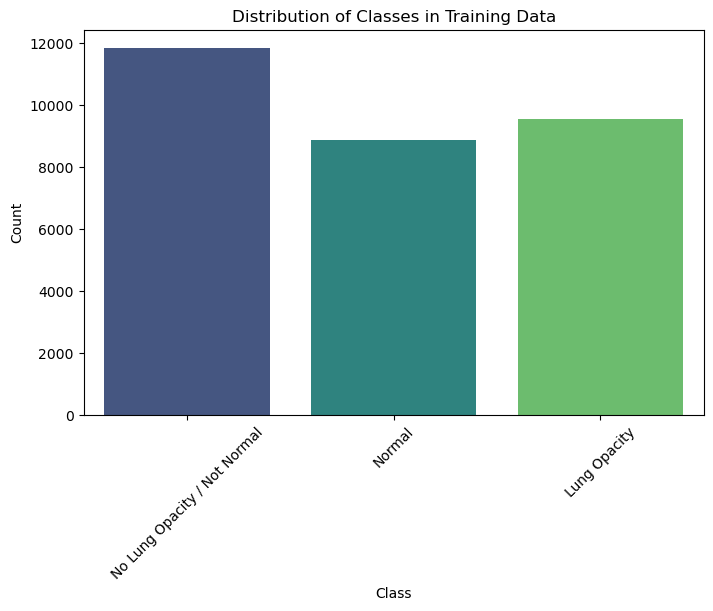

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution count
class_distribution = train_data_merged['class'].value_counts()
print("\nClass distribution:\n", class_distribution)

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=train_data_merged, palette='viridis', hue='class')
plt.title("Distribution of Classes in Training Data")
plt.ylabel("Count")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.show()


In [29]:
# Inspect the test set (sample submission file)
print("\nTest Set Sample Submission Preview:")
print(sample_submission_cleaned.head())



Test Set Sample Submission Preview:
                              patientId PredictionString
0  0000a175-0e68-4ca4-b1af-167204a7e0bc  0.5 0 0 100 100
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813  0.5 0 0 100 100
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6  0.5 0 0 100 100
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d  0.5 0 0 100 100
4  00100a24-854d-423d-a092-edcf6179e061  0.5 0 0 100 100


In [ ]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

labeled_barplot(train_data_merged, "class")

In [ ]:
labeled_barplot(train_data_merged, "Target")

### **Map Training Images to Their Annotations**

#### Map patient IDs to their bounding boxes

In [ ]:
# Group annotations by patientId clearly
annotations_grouped = train_data_merged.groupby('patientId')

# Example: Display annotations for a specific patient clearly
sample_patient = train_data_merged[train_data_merged['Target'] == 1]['patientId'].iloc[0]

print(f"\nBounding Boxes for patientId '{sample_patient}':")
print(annotations_grouped.get_group(sample_patient))



Bounding Boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
                              patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1


#### Create a convenient annotation dictionary

In [31]:
# Create dictionary mapping patientId to list of bounding boxes (coordinates)
bbox_dict = {}

for patientId, group in annotations_grouped:
    bboxes = group[['x', 'y', 'width', 'height', 'Target']].values
    bbox_dict[patientId] = bboxes

# Verify clearly
print(f"Bounding boxes for patientId '{sample_patient}':")
print(bbox_dict[sample_patient])


Bounding boxes for patientId '00436515-870c-4b36-a041-de91049b9ab4':
[[264. 152. 213. 379.   1.]
 [562. 152. 256. 453.   1.]]


#### Summary of Bounding Box Data

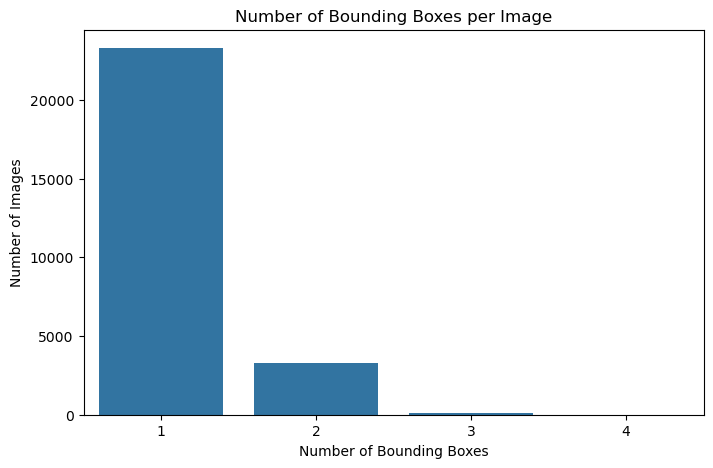

In [ ]:
# Bounding boxes co-ordinates
plt.figure(figsize=(8, 5))
pneumonia_boxes = train_data_merged[train_data_merged['binary_target'] == 1]
plt.scatter(pneumonia_boxes['x'], pneumonia_boxes['y'], alpha=0.3, s=10)
plt.title("Bounding Box Top-Left Coordinates")
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

### Step 4: Preprocessing and Visualization of Different Classes

In [ ]:
# Function to load and preprocess DICOM image
def load_dicom_image(patient_id, img_size=(224, 224)):
    """
    Load and preprocess a DICOM image for a given patient ID

    Parameters:
    - patient_id: ID of the patient
    - img_size: Tuple of (height, width) for resizing

    Returns:
    - Preprocessed image as numpy array
    """
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    # Convert to numpy array
    image = dicom.pixel_array

    # Normalize pixel values to be between 0 and 1
    image = image / np.max(image)

    # Convert to grayscale if necessary
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize image
    image = cv2.resize(image, img_size[::-1])

    # Expand dimensions for CNN input (add channel dimension)
    image = np.expand_dims(image, axis=-1)

    return image

In [ ]:
# Sample a few images from each class for visualization
def sample_patients_from_class(class_name, n=4):
    """Sample n patient IDs from a given class"""
    return random.sample(list(train_data_merged[train_data_merged['class'] == class_name]['patientId']), n)

# Sample patient IDs from each class
normal_patients = sample_patients_from_class('Normal',3)
opacity_patients = sample_patients_from_class('Lung Opacity',3)
not_normal_patients = sample_patients_from_class('No Lung Opacity / Not Normal',3)

In [ ]:
# Plot sample images from each class
plt.figure(figsize=(15, 10))

# Plot Normal images
for i, patient_id in enumerate(normal_patients):
    plt.subplot(3, 3, i+1)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Normal: {patient_id[:8]}...")
    plt.axis('off')

# Plot Lung Opacity images
for i, patient_id in enumerate(opacity_patients):
    plt.subplot(3, 3, i+4)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Lung Opacity: {patient_id[:8]}...")
    plt.axis('off')

# Plot Not Normal No Lung Opacity images
for i, patient_id in enumerate(not_normal_patients):
    plt.subplot(3, 3, i+7)
    img = load_dicom_image(patient_id)
    plt.imshow(img[:, :, 0], cmap='gray')
    plt.title(f"Not Normal: {patient_id[:8]}...")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Function to load DICOM image with original size
def load_original_dicom(patient_id):
    """Load DICOM image without resizing"""
    zip_path = 'stage_2_train_images.zip'
    zip_archive = zipfile.ZipFile(zip_path, 'r')

    dicom_filename = f"stage_2_train_images/{patient_id}.dcm"

    if dicom_filename not in zip_archive.namelist():
        raise FileNotFoundError(f"{dicom_filename} not found in ZIP archive.")

    # Read file as bytes and load with pydicom
    with zip_archive.open(dicom_filename) as file:
        dicom_bytes = file.read()
        dicom = pydicom.dcmread(io.BytesIO(dicom_bytes))

    image = dicom.pixel_array
    image = image / np.max(image)
    if image.ndim > 2:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image

In [ ]:
# Function to draw bounding boxes on image
def draw_boxes(image, boxes):
    """Draw bounding boxes on the image"""

    # Ensure image is in uint8 format (0-255)
    if image.dtype != np.uint8:
        # Normalize to 0-255 and convert to uint8
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)

    # Convert grayscale image to RGB for colored boxes
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    for box in boxes:
        x, y = int(box['x']), int(box['y'])
        w, h = int(box['width']), int(box['height'])
        image_color = cv2.rectangle(image_color, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return image_color

In [ ]:
# Sample a few patients with Lung Opacity (which have bounding boxes)
opacity_patients = sample_patients_from_class('Lung Opacity')
opacity_with_boxes = [pid for pid in opacity_patients if pid in patient_boxes]

if not opacity_with_boxes:
    opacity_with_boxes = list(set(patient_boxes.keys()) &
                             set(train_data_merged[train_data_merged['class'] == 'Lung Opacity']['patientId']))[:4]


In [ ]:
# Plot images with bounding boxes
plt.figure(figsize=(15, 15))

for i, patient_id in enumerate(opacity_with_boxes[:4]):
    try:
        plt.subplot(2, 2, i + 1)
        img = load_original_dicom(patient_id)

        if img is None:
            print(f"[Warning] Image for patient {patient_id} is None.")
            continue

        if patient_id in patient_boxes:
            img_with_boxes = draw_boxes(img, patient_boxes[patient_id])
            plt.imshow(img_with_boxes, cmap='gray')
        else:
            plt.imshow(img, cmap='gray')

        plt.title(f"Patient: {patient_id[:9]}... (Lung Opacity)")
        plt.axis('off')

    except Exception as e:
        print(f"[Error] Failed on patient {patient_id}: {e}")

plt.tight_layout()
plt.show()


#### **Inspect Class Distribution**

C:\Users\nkpat\AppData\Local\Temp\ipykernel_20676\3668924464.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=train_data_merged, palette='viridis')


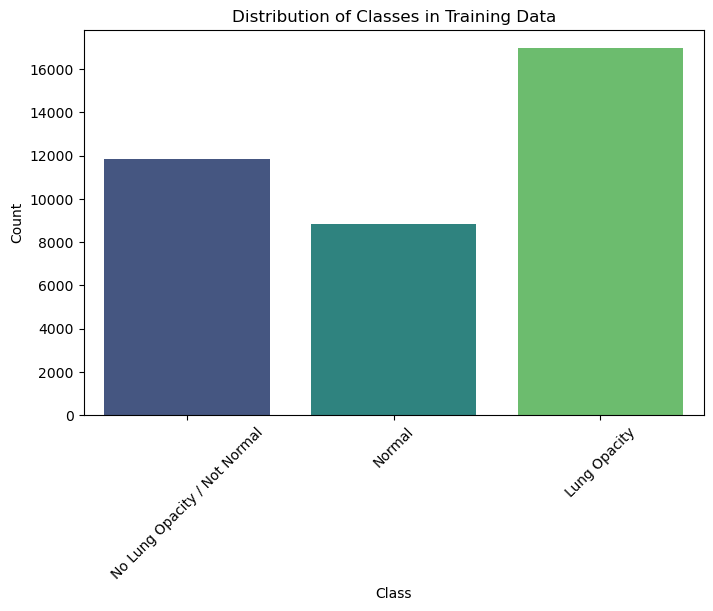

In [ ]:
# Visualize distribution of bounding box dimensions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(train_data_merged['width'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Bounding Box Widths')
plt.xlabel('Width')

plt.subplot(1,2,2)
sns.histplot(train_data_merged['height'], bins=10, kde=True, color='salmon')
plt.title('Distribution of Bounding Box Heights')
plt.xlabel('Height')

plt.tight_layout()
plt.show()


In [ ]:
# Create a scatter plot of bounding box positions
plt.figure(figsize=(8,8))
sns.scatterplot(
    x='x', y='y',
    hue='Target',
    size='width', sizes=(20, 200),
    data=train_data_merged, palette=['green', 'red']
)
plt.title('Bounding Box Positions by Class')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates
plt.show()

In [ ]:
# Calculate centers of bounding boxes
train_data_merged['center_x'] = train_data_merged['x'] + train_data_merged['width']/2
train_data_merged['center_y'] = train_data_merged['y'] + train_data_merged['height']/2

# Create separate DataFrames for each class
pneumonia_df = train_data_merged[train_data_merged['Target'] == 1]

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Pneumonia heatmap
sns.kdeplot(x=pneumonia_df['center_x'], y=pneumonia_df['center_y'],
            cmap='Reds', fill=True, ax=ax1)
ax1.set_title('Pneumonia Annotation Density')
ax1.invert_yaxis()

plt.tight_layout()
plt.show()


### **Design, Train, and Test Basic CNN Models**

#### **Encode Labels and Prepare Train/Validation Split**

In [ ]:
# Prepare class labels
le = LabelEncoder()
train_data_merged['label'] = le.fit_transform(train_data_merged['class'])

# Train/Validation split
train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_data_merged['patientId'], train_data_merged['label'], stratify=train_data_merged['label'], test_size=0.2, random_state=42)


#### **Data Generators**

In [56]:

class PneumoniaDataGenerator(Sequence):
    def __init__(self, patient_ids, labels, processor, batch_size=32, image_size=256, shuffle=True):
        self.patient_ids = list(patient_ids)
        self.labels = list(labels)
        self.processor = processor
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.patient_ids) // self.batch_size

    def __getitem__(self, index):
        ids = self.patient_ids[index * self.batch_size:(index + 1) * self.batch_size]
        y = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        X = np.array([self.processor.get_resized_dicom_image(pid, size=self.image_size) for pid in ids])
        y = to_categorical(y, num_classes=3)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.patient_ids, self.labels))
            random.shuffle(temp)
            self.patient_ids, self.labels = zip(*temp)


In [57]:
class MobileNetDataGenerator(PneumoniaDataGenerator):
    def __getitem__(self, index):
        X, y = super().__getitem__(index)
        X = np.repeat(X, 3, axis=-1)  # convert (H, W, 1) -> (H, W, 3)
        return X, y


#### **ModelBuilder**

In [ ]:

class ModelBuilder:
    def __init__(self, input_shape, num_classes=3):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_basic_cnn(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2, 2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        return model

    def build_deeper_cnn(self):
        model = Sequential([
            Conv2D(32, (3,3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(2, 2),
            Conv2D(64, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(128, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Conv2D(256, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        return model

    def build_lenet5(self):
        model = Sequential([
            Input(shape=self.input_shape),
            Conv2D(6, kernel_size=(5, 5), activation='tanh'),
            AveragePooling2D(pool_size=(2, 2)),
            Conv2D(16, kernel_size=(5, 5), activation='tanh'),
            AveragePooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(120, activation='tanh'),
            Dense(84, activation='tanh'),
            Dense(self.num_classes, activation='softmax')
        ])
        return model
        
    def build_mobilenetv2(self):
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
        base_model.trainable = False

        inputs = Input(shape=(256, 256, 3))
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu')(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        return model


#### **TrainingManager**

In [ ]:
class TrainingManager:
    def __init__(self, processor, train_ids, train_labels, val_ids, val_labels, batch_size=32):
        self.processor = processor
        self.train_ids = train_ids
        self.train_labels = train_labels
        self.val_ids = val_ids
        self.val_labels = val_labels
        self.batch_size = batch_size

    def get_generator(self, model_type):
        if model_type == 'MobileNetV2':
            return (
                MobileNetDataGenerator(self.train_ids, self.train_labels, self.processor, batch_size=self.batch_size),
                MobileNetDataGenerator(self.val_ids, self.val_labels, self.processor, batch_size=self.batch_size)
            )
        else:
            return (
                PneumoniaDataGenerator(self.train_ids, self.train_labels, self.processor, batch_size=self.batch_size),
                PneumoniaDataGenerator(self.val_ids, self.val_labels, self.processor, batch_size=self.batch_size)
            )

    def train_model(self, model_type: str, epochs=5):
        input_shape = (256, 256, 1) if model_type != 'MobileNetV2' else (256, 256, 3)
        builder = ModelBuilder(input_shape=input_shape)

        if model_type == 'BasicCNN':
            model = builder.build_basic_cnn()
        elif model_type == 'DeeperCNN':
            model = builder.build_deeper_cnn()
        elif model_type == 'MobileNetV2':
            model = builder.build_mobilenetv2()
        elif model_type == 'lenet5':
            model = builder.build_lenet5()
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
        train_gen, val_gen = self.get_generator(model_type)

        print(f"\n🔧 Training: {model_type}")
        history = model.fit(train_gen, validation_data=val_gen, epochs=epochs)
        return model, history


#### **Train All Models**

In [60]:
trainer = TrainingManager(
    processor=train_images,
    train_ids=train_ids,
    train_labels=train_labels,
    val_ids=val_ids,
    val_labels=val_labels
)

models = {}
histories = {}

for model_type in ['BasicCNN', 'DeeperCNN', 'MobileNetV2']:
    model, history = trainer.train_model(model_type=model_type, epochs=5)
    models[model_type] = model
    histories[model_type] = history



🔧 Training: BasicCNN
Epoch 1/5
667/667 [==============================] - 749s 1s/step - loss: 0.9329 - accuracy: 0.5394 - val_loss: 0.8811 - val_accuracy: 0.5612
Epoch 2/5
667/667 [==============================] - 757s 1s/step - loss: 0.8729 - accuracy: 0.5731 - val_loss: 0.8295 - val_accuracy: 0.5994
Epoch 3/5
667/667 [==============================] - 728s 1s/step - loss: 0.8433 - accuracy: 0.5955 - val_loss: 0.8151 - val_accuracy: 0.6082
Epoch 4/5
667/667 [==============================] - 736s 1s/step - loss: 0.8185 - accuracy: 0.6082 - val_loss: 0.7942 - val_accuracy: 0.6258
Epoch 5/5
667/667 [==============================] - 741s 1s/step - loss: 0.7888 - accuracy: 0.6270 - val_loss: 0.7876 - val_accuracy: 0.6329

🔧 Training: DeeperCNN
Epoch 1/5
667/667 [==============================] - 790s 1s/step - loss: 0.9503 - accuracy: 0.5174 - val_loss: 0.8581 - val_accuracy: 0.5787
Epoch 2/5
667/667 [==============================] - 805s 1s/step - loss: 0.8711 - accuracy: 0.5746 - v

#### **Plot Validation Accuracy Comparison**

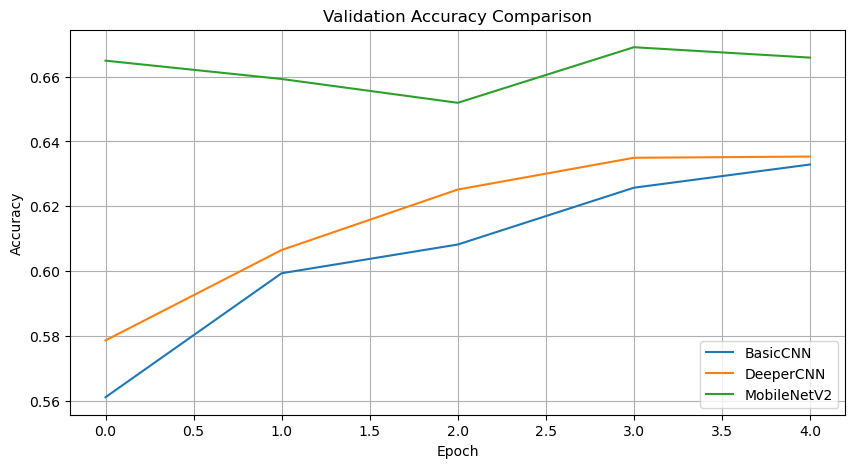

In [61]:

plt.figure(figsize=(10,5))
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=f"{name}")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Step 7: Interim Report